In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:


# ======================
# 1. Cargar y preparar datos
# ======================
df = pd.read_excel("../Datos/DB_Comentarios_Clean.xlsx")
df = df.dropna(subset=["comentario", "calificacion"])

# Mapeo binario
rating_to_label = {1: "negativo", 2: "negativo", 3: "negativo", 4: "positivo", 5: "positivo"}
label_to_int = {"negativo": 0, "positivo": 1}
int_to_label = {0: "negativo", 1: "positivo"}
df["sentimiento"] = df["calificacion"].map(rating_to_label)
df["sentimiento_id"] = df["sentimiento"].map(label_to_int)

# División general train/test
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df["comentario"], df["sentimiento_id"], test_size=0.2, stratify=df["sentimiento_id"], random_state=42
)




✅ Entrenamiento finalizado: 100 modelos entrenados

📊 Accuracy: 0.8782

📋 Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.41      1.00      0.58        81
    Positivo       1.00      0.87      0.93       863

    accuracy                           0.88       944
   macro avg       0.71      0.93      0.76       944
weighted avg       0.95      0.88      0.90       944


🧩 Matriz de Confusión:


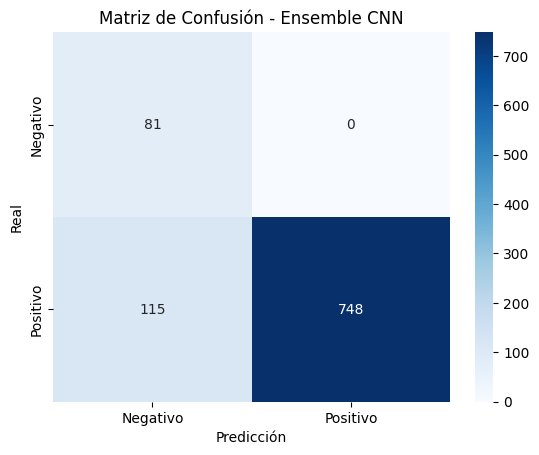

In [6]:
# ======================
# 2. Tokenización
# ======================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100
NUM_EPOCHS = 10

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

# Convertir texto a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

# ======================
# 3. Definir función de modelo base
# ======================
def build_model():
    model = Sequential([
        Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ======================
# 4. Ensemble con undersampling balanceado
# ======================
df_neg = df[df["sentimiento_id"] == 0]
df_pos = df[df["sentimiento_id"] == 1]

N = 100
modelos = []

for i in range(N):
    df_pos_sample = resample(df_pos, replace=False, n_samples=len(df_neg), random_state=42 + i)
    df_bal = pd.concat([df_pos_sample, df_neg]).sample(frac=1, random_state=42 + i)

    X_bal_seq = tokenizer.texts_to_sequences(df_bal["comentario"])
    X_bal_pad = pad_sequences(X_bal_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    y_bal = df_bal["sentimiento_id"].values

    model_i = build_model()
    model_i.fit(X_bal_pad, y_bal, epochs=NUM_EPOCHS, batch_size=32, verbose=0)
    modelos.append(model_i)

print(f"\n✅ Entrenamiento finalizado: {N} modelos entrenados")

# ======================
# 5. Predicción por votación
# ======================
preds = np.array([model.predict(X_test_pad, verbose=0).flatten() for model in modelos])
promedio_preds = np.mean(preds, axis=0)
y_pred_binario = (promedio_preds > 0.4).astype(int)

# ======================
# 6. Evaluación
# ======================
print(f"\n📊 Accuracy: {accuracy_score(y_test, y_pred_binario):.4f}")
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_binario, target_names=["Negativo", "Positivo"], digits=2))

print("\n🧩 Matriz de Confusión:")
conf_matrix = confusion_matrix(y_test, y_pred_binario)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negativo", "Positivo"],
            yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Ensemble CNN")
plt.show()

In [7]:
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                            roc_auc_score, precision_recall_curve, auc, 
                            cohen_kappa_score, balanced_accuracy_score, log_loss, 
                            roc_curve)

🔵 ROC AUC: 0.9955
🟢 Precision-Recall AUC: 0.9996
🟡 Cohen's Kappa: 0.5275
🟣 Balanced Accuracy: 0.9334
🔴 Specificity (Recall Negativo): 1.0000
⚫ Log Loss: 0.3069


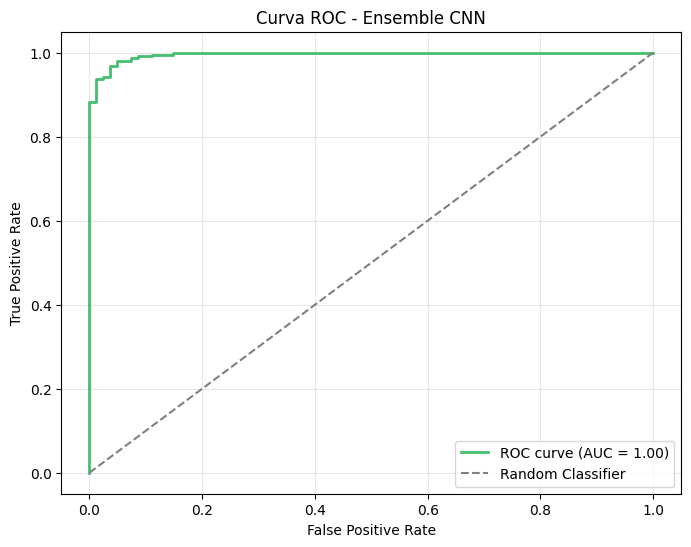

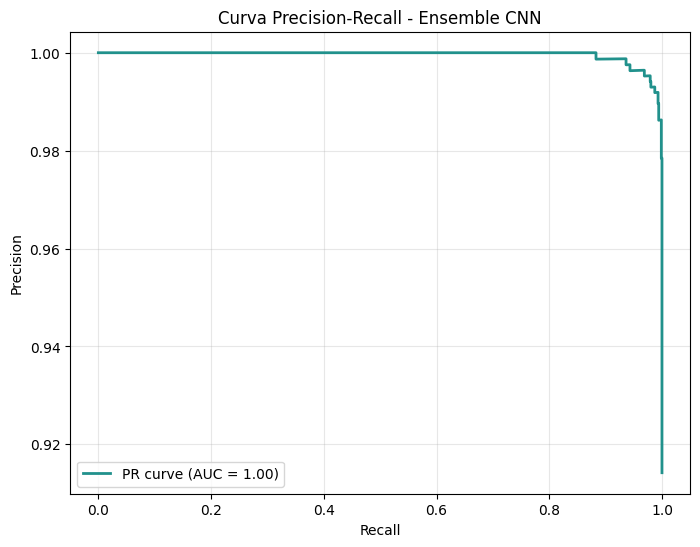

In [8]:
# ======================
# 7. Métricas adicionales
# ======================
# ROC AUC
roc_auc = roc_auc_score(y_test, promedio_preds)
print(f"🔵 ROC AUC: {roc_auc:.4f}")

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, promedio_preds)
pr_auc = auc(recall, precision)
print(f"🟢 Precision-Recall AUC: {pr_auc:.4f}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_binario)
print(f"🟡 Cohen's Kappa: {kappa:.4f}")

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred_binario)
print(f"🟣 Balanced Accuracy: {balanced_acc:.4f}")

# Specificity (Recall Negativo)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binario).ravel()
specificity = tn / (tn + fp)
print(f"🔴 Specificity (Recall Negativo): {specificity:.4f}")

# Log Loss
logloss = log_loss(y_test, promedio_preds)
print(f"⚫ Log Loss: {logloss:.4f}")

# ======================
# 8. Curva ROC
# ======================
fpr, tpr, _ = roc_curve(y_test, promedio_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=plt.cm.viridis(0.7), lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Ensemble CNN')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ======================
# 9. Curva Precision-Recall
# ======================
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color=plt.cm.viridis(0.5), lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Ensemble CNN')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()


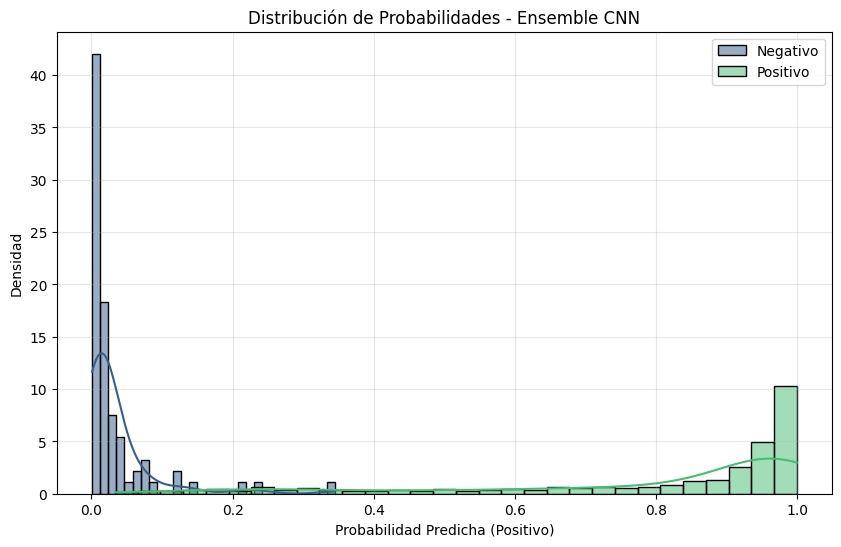

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creamos un DataFrame para facilitar el plot
df_preds = pd.DataFrame({
    'Probabilidad_Positivo': promedio_preds,
    'Clase_Real': y_test
})

# Plot tipo KDE + histograma para ambas clases
plt.figure(figsize=(10, 6))

sns.histplot(data=df_preds[df_preds['Clase_Real'] == 0], x='Probabilidad_Positivo', 
             color=plt.cm.viridis(0.3), kde=True, label='Negativo', stat='density', bins=30, alpha=0.5)

sns.histplot(data=df_preds[df_preds['Clase_Real'] == 1], x='Probabilidad_Positivo', 
             color=plt.cm.viridis(0.7), kde=True, label='Positivo', stat='density', bins=30, alpha=0.5)

# Estilo y detalles
plt.xlabel('Probabilidad Predicha (Positivo)')
plt.ylabel('Densidad')
plt.title('Distribución de Probabilidades - Ensemble CNN')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


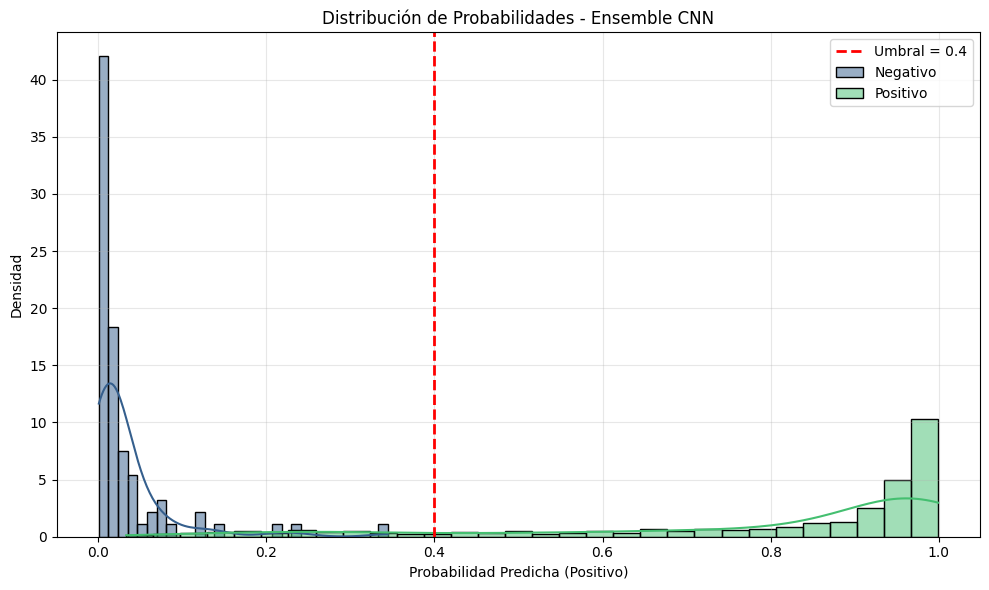

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creamos un DataFrame para facilitar el plot
df_preds = pd.DataFrame({
    'Probabilidad_Positivo': promedio_preds,
    'Clase_Real': y_test
})

# Plot tipo KDE + histograma para ambas clases
plt.figure(figsize=(10, 6))

sns.histplot(data=df_preds[df_preds['Clase_Real'] == 0], x='Probabilidad_Positivo', 
             color=plt.cm.viridis(0.3), kde=True, label='Negativo', stat='density', bins=30, alpha=0.5)

sns.histplot(data=df_preds[df_preds['Clase_Real'] == 1], x='Probabilidad_Positivo', 
             color=plt.cm.viridis(0.7), kde=True, label='Positivo', stat='density', bins=30, alpha=0.5)

# Línea vertical para el umbral de decisión en 0.4
plt.axvline(x=0.4, color='red', linestyle='--', linewidth=2, label='Umbral = 0.4')

# Estilo y detalles
plt.xlabel('Probabilidad Predicha (Positivo)')
plt.ylabel('Densidad')
plt.title('Distribución de Probabilidades - Ensemble CNN')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
